#### Importing Libraries

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
import math

#### Load Ted's face

In [2]:
keanu = imread('keanu.jpg')

#### Create a list of sigma's to iterate over

In [3]:
sigmas = [20, 15, 12, 10, 1, 0.5]

Note: In the included document for the homework assignment, `fspecial()` for MATLAB took size of gaussian kernel as an argument (hsize), hence it was necessary to use the formula given in the slides $radius = 2*ceil(sigma)+1$. As of current versions of MATLAB `fspecial()` has been deprecated for `imgaussfilt()` which automatically implements filter size as given [here](https://www.mathworks.com/help/images/ref/imgaussfilt.html). Similarly, the equivalent function in Python that I'm using `skimage.filters.gaussian()` is a wrapper around `scipy.ndi.gaussian()` which implements the Gaussian filter similarly. Hence, there is no need to pass the second argument. [Source for Python function](https://github.com/scipy/scipy/blob/v0.14.0/scipy/ndimage/filters.py#L250)

# Perform Gaussian smoothing over Keanu's face 

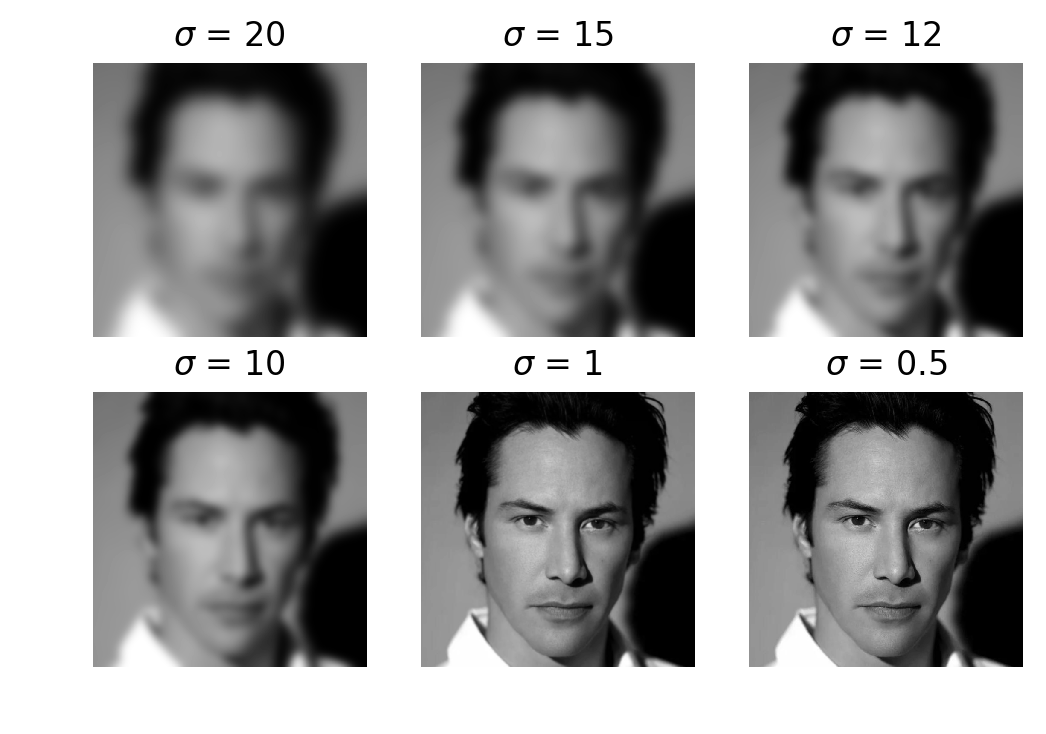

In [4]:
plt.close('all')
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for sigma in sigmas:
    filteredIm = gaussian(keanu, sigma)
    idx = sigmas.index(sigma)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'$\sigma$ = {sigma}')
    axarr[int(idx/3), idx%3].imshow(filteredIm, cmap = 'gray', aspect='auto')

Notice that the list of $\sigma$s used in the above example doesn't follow any linear or even log-linear scale. This is because I have chosen these values after some trial and error with my friends in order of cognitive difficulty in terms of identifying Keanu Reeves. Interesting observation I found was $\sigma=10$ was the point of most controversy, as this seems like the value where some of my friends were able to identify but others were clueless. Also interesting to note is that $\sigma$ values less than 5 seem to have no effect on anyone.

# Function to compute and display 2D Gaussian Derivative masks

From the class notes, we know that,

$$G_x = \frac{-x}{2\pi\sigma^4}e^{-\frac{x^2 + y^2}{2\sigma}}$$
$$G_y = \frac{-y}{2\pi\sigma^4}e^{-\frac{x^2 + y^2}{2\sigma}}$$

From the above set of equations and comparing with instructions presented in our homework document, we can implement a naive derivative filter to be used with `sklearn.ndi.generic_filter`.

```
def gaussX(sigma):
    l = 2 * sigma + 1
    ax = np.arange(-l, l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = -(xx * np.exp(-(xx**2 + yy**2) / (2. * sigma**2)))/ (2*math.pi* (sigma**4))

    kernel = kernel / np.sum(kernel)

    return kernel

def gaussY(sigma):
    l = 2 * sigma + 1
    ax = np.arange(-l, l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = -(yy * np.exp(-(xx**2 + yy**2) / (2. * sigma**2)))/ (2*math.pi* (sigma**4))

    kernel = kernel / np.sum(kernel)

    return kernel
```

The reason why I haven't done this is because, while its relatively easy to implement the filter itself this way, due to the way skimage processes, applying the filter becomes a pain point in terms of applying it programmatically.

Instead I choose to apply the same derivative using a more efficient method (drawn from our class discussion of being able to split a gaussian filter into two steps of 1D filters).

This is calculated by creating a base gaussian kernel given by $k = \frac{1}{2\pi\sigma}\sum e^{\frac{x^2}{2\sigma}}$ then multiplying, $t = \frac{x}{\sigma^2}$, thus we get our $G_x$ and $G_y$ respectively.

Implementing it this way, also allows us to transpose our $G_x$ to get $G_y$ and thus provides for a succint implementation of the required function

In [5]:
from scipy.ndimage.filters import correlate1d
from scipy.ndimage.filters import _ni_support
from skimage.color import guess_spatial_dimensions
from skimage._shared.utils import convert_to_float
from scipy import ndimage as ndi

def gaussian_derivative_filter1d(input, sigma, axis=-1, output=None,mode="reflect", cval=0.0, truncate=4.0):
    
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd = sd * sd
    # calculate the kernel:
    for ii in range(1, lw + 1):
        tmp = math.exp(-0.5 * float(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum
    # implement first order derivative:
    weights[lw] = 0.0
    for ii in range(1, lw + 1):
        x = float(ii)
        tmp = -x / sd * weights[lw + ii]
        weights[lw + ii] = -tmp
        weights[lw - ii] = tmp
    return correlate1d(input, weights, axis, output, mode, cval, 0)

def gaussDerive2D(input, sigma, output=None):
    input = np.asarray(input)
    output = _ni_support._get_output(None, input)
    sigmas = _ni_support._normalize_sequence(sigma, input.ndim)
    axes = list(range(input.ndim))
    axes = [(axes[ii], sigmas[ii])
                        for ii in range(len(axes)) if sigmas[ii] > 1e-15]
    if len(axes) > 0:
        for axis, sigma in axes:
            gaussian_derivative_filter1d(input, sigma, axis, output)
            input = output
    else:
        output[...] = input[...]
    return output

def gaussDeriveApplyFilter(image, sigma=1, output=None, mode='nearest', cval=0,multichannel=None, preserve_range=False, truncate=4.0):
    spatial_dims = guess_spatial_dimensions(image)
    if np.any(np.asarray(sigma) < 0.0):
        raise ValueError("Sigma values less than zero are not valid")
    if multichannel:
        # do not filter across channels
        if not isinstance(sigma, coll.Iterable):
            sigma = [sigma] * (image.ndim - 1)
        if len(sigma) != image.ndim:
            sigma = np.concatenate((np.asarray(sigma), [0]))
    image = convert_to_float(image, preserve_range)
    return gaussDerive2D(image, sigma)

# Compute and Display the effect of our filter

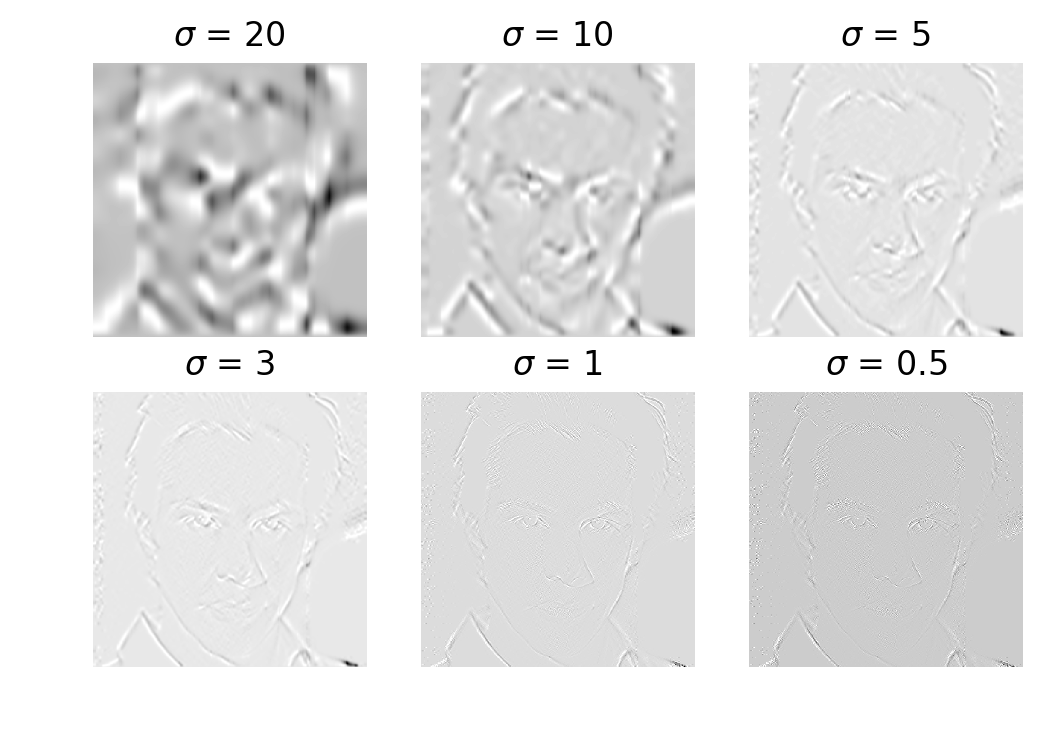

In [6]:
from sklearn.preprocessing import normalize

sigmas = [20, 10, 5, 3, 1, 0.5]

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for sigma in sigmas:
    magIm = gaussDeriveApplyFilter(keanu, sigma)
    magIm = normalize(magIm, axis=0, norm='max') * 255.0
    idx = sigmas.index(sigma)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'$\sigma$ = {sigma}')
    axarr[int(idx/3), idx%3].imshow(magIm, cmap = 'gray', aspect='auto')

Note: Due to conversion of float to int while displaying, the `cmap='gray'` acts a little wonky, but functionally there is little difference

# Threshold with different T levels

In [7]:
magIm = gaussDeriveApplyFilter(keanu, sigma = 3)

#magIm = (magIm - magIm.min(0)) *255.0 / magIm.ptp(0)

magIm = normalize(magIm, axis=0, norm='max') * 255.0

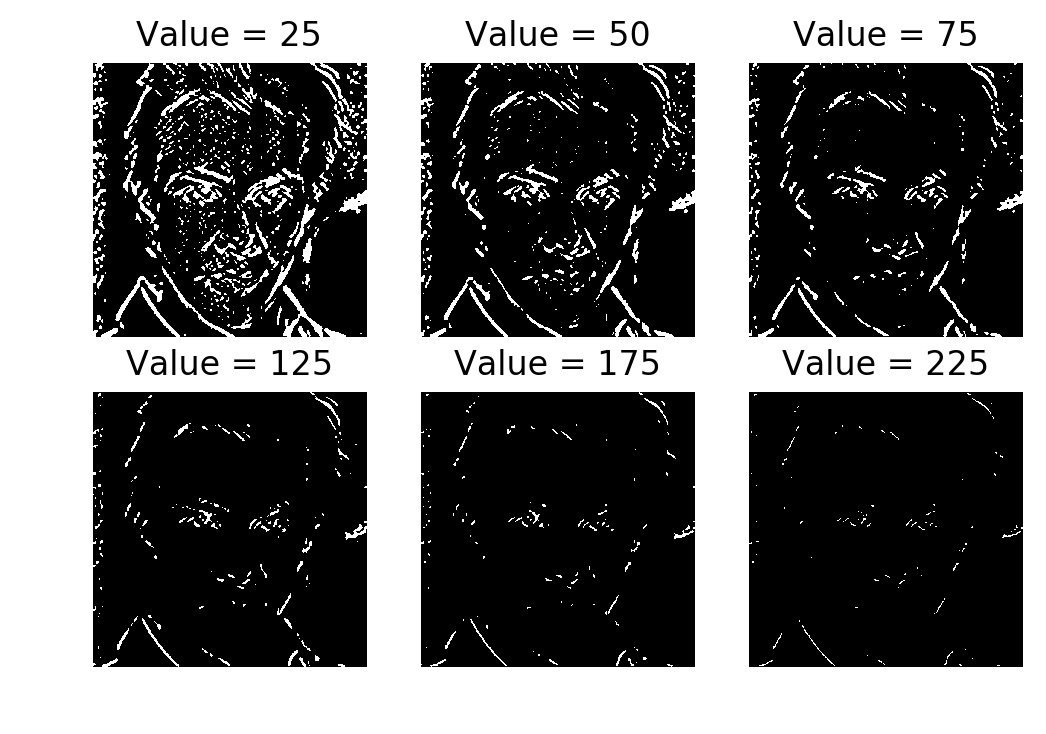

In [8]:
threshLevels = [25, 50, 75, 125, 175, 225]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    tImg = magIm > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'Value = {thresh}')
    axarr[int(idx/3), idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

We notice that our native implementation, when thresholded properly ( value of 50) generates a semi-decent edge detector. But due to the calculation of gaussian manually and what seems to be precision round off errors, we can notice some grainy-ness in the final result. (There are some specks of activation on the forehead for example). Later we would observe that Sobel operator gives a similar result without the grainyness because of (what I assume is) the kernel using whole numbers.

# Compare with Sobel masks

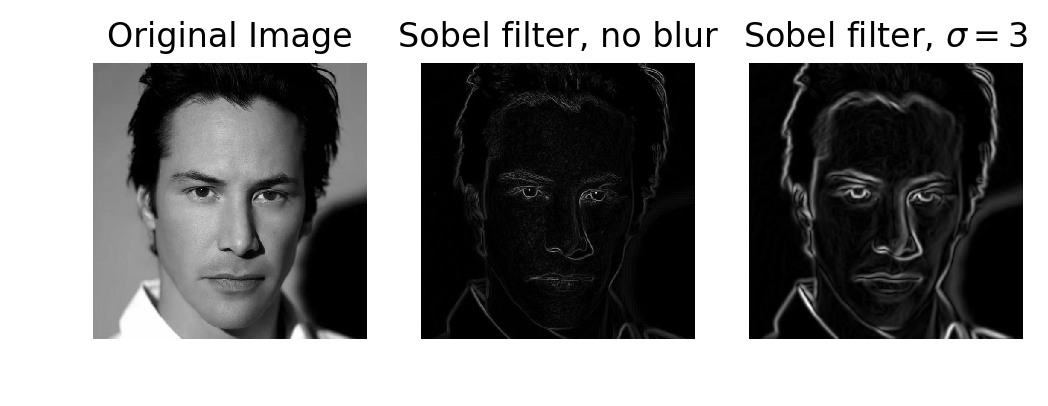

In [9]:
from skimage.filters import sobel

edges1 = sobel(keanu)
edges2 = sobel(gaussian(keanu, sigma=3))

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, dpi=200,
                                    sharex=True, sharey=True)

ax1.imshow(keanu, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Sobel filter, no blur')

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Sobel filter, $\sigma=3$')

plt.show()

From the above image we can see that the sobel filter generates a more fine and smooth lines for the edges compared to the gaussian derivative filter that we created. In order to account for the difference in smoothing, if we try to blur the image before applying Sobel's filter, we would intuitively expect the lines to become more continuous, but upon doing so we see that the blurring only makes the edges more prominent and doesn't improve the overall continuity of the edges.

# Canny Edge detector

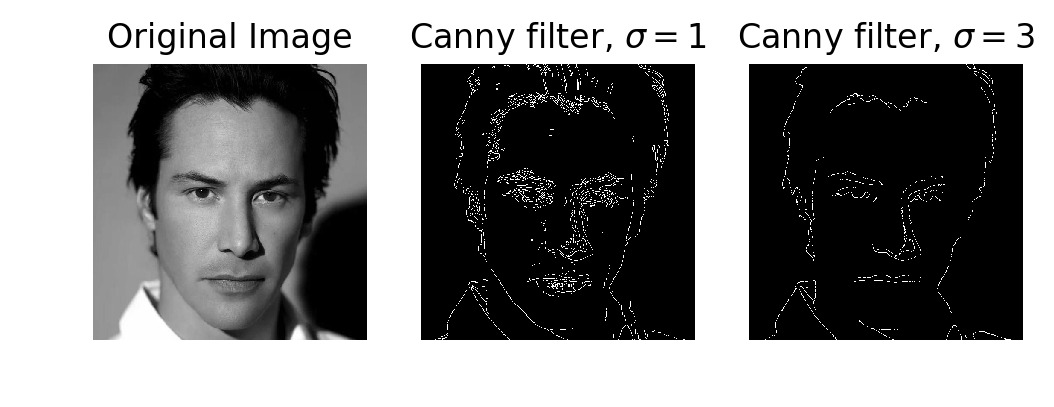

In [10]:
from scipy import ndimage as ndi

from skimage import feature

edges1 = feature.canny(keanu)
edges2 = feature.canny(keanu, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, dpi=200,
                                    sharex=True, sharey=True)

ax1.imshow(keanu, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$')

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$')

plt.show()


We can see that unlike Sobel or our Gaussian derivative filter, the canny edge detector generates a more complete contour line that is continuous. Even upon increasing $\sigma$ we can observe that we do not loose the continuity, but some of the smaller less relevant features like eyebrows or tufts of hairline are not detected as edges. This version would work better for something like face recognization feature.

Though the homework ends here, I have included some optional bonus stuff that illustrates some fun little uses of the things we've learnt so far.

# Optional: Etch-a-sketch effect

This is a fun little exercise where we can apply Sobel's operator with some pre-processing to generate "sketch-like" effect.
The pre-processing entails a simple gaussian blur for making the edges more prominent, then applying sobel operator and thresholding it to generate what appears to be pencil strokes. (Also the thickness of the pencil is determined by the strength of our blur)

/usr/lib/python3.7/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


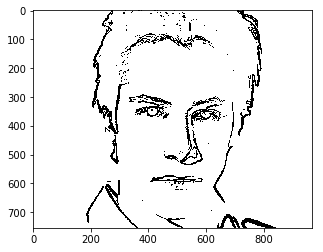

In [11]:
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.filters import sobel, threshold_otsu

keanu_colour = imread('keanu_colour.jpg')

blur_keanu = gaussian(keanu_colour)

clean_keanu = rgb2gray(blur_keanu)

edge_keanu = sobel(clean_keanu)

thresh_mesh = threshold_otsu(edge_keanu)

binary_keanu = edge_keanu > thresh_mesh

plt.imshow(invert(binary_keanu), cmap = 'gray')

# Optional: A Scanner Darkly Effect using Image Segmentation

Note: The effect used in the movie is actually a [cel-shading effect](https://www.wikiwand.com/en/Cel_shading), which is performed by computing the normals for world surfaces (which uses 3D models) and blending them with the Sobel operator (used for edges to give "Toon"-lines). Since, we work with a 2D image for our course, I will be using Image Segmentation to achieve a similar effect, albeit one that's more simplistic looking.

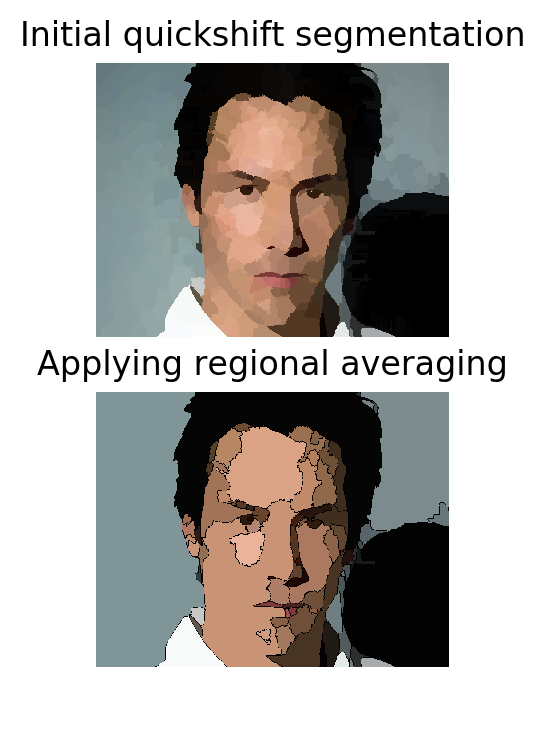

In [12]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


keanu_colour = imread('keanu_colour.jpg')

labels1 = segmentation.quickshift(keanu_colour, kernel_size=7, max_dist=6, ratio=0.5)
out1 = color.label2rgb(labels1, keanu_colour, kind='avg')

g = graph.rag_mean_color(keanu_colour, labels1)
labels2 = graph.cut_threshold(labels1, g, 20)
out2 = color.label2rgb(labels2, keanu_colour, kind='avg')
out2 = segmentation.mark_boundaries(out2, labels2, (0, 0, 0))
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, dpi=200)

ax[0].imshow(out1)
ax[0].set_title('Initial quickshift segmentation')
ax[1].imshow(out2)
ax[1].set_title('Applying regional averaging')
for a in ax:
    a.axis('off')

#plt.tight_layout()